<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/4_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part - 4: Proposed and train 3-6 models
 - Compare the model performance using RMSE between the fitted Y and actual Y in testing period

## Importing libraries

In [13]:
# %%bash

# pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow


In [14]:
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb
from sklearn.linear_model import Lasso
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (15, 20)

## MLFlow Experiment Tracking

In [22]:
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://localhost:5001"
SET_EXPERIMENT = "INFO7374_Testing"
EXPERIMENT_ID = "2"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(SET_EXPERIMENT)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
mlflow.sklearn.autolog(silent=True)
mlflow.xgboost.autolog(silent=True)
mlflow.statsmodels.autolog()

2024/01/11 01:21:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.


## NVIDIA Latest Prices

In [23]:
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 12, 31)

NVDA_STOCK = yf.download("NVDA", start_date, end_date)
NVDA_STOCK.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-03,425.170013,428.980011,422.019989,424.130005,424.057770,19820900
2023-07-05,421.350006,431.769989,420.850006,423.170013,423.097961,32361800
2023-07-06,418.440002,421.790009,413.459991,421.029999,420.958313,30358200
2023-07-07,423.220001,432.140015,421.799988,425.029999,424.957642,35525300
2023-07-10,426.570007,428.109985,416.489990,421.799988,421.728149,35390800


## Train & Test Data Split

In [24]:
nvda = pd.read_csv("https://raw.githubusercontent.com/piyush-an/INFO7374_Predict_StockPrice/main/NVDA_feature_mart.csv")
nvda.set_index("Unnamed: 0", inplace=True)

nvda.index = pd.to_datetime(nvda.index)
nvda = nvda[nvda.index >= pd.to_datetime("2022-01-01")]
split_date = pd.to_datetime("2023-07-31")

df_train = nvda[nvda.index <= split_date]
df_test = nvda[nvda.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price", "Adj Close"]

X_train = df_train.loc[:, df_train.columns != "Close"][:-1]
X_train = X_train.drop(columns_to_drop, axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test.loc[:, df_test.columns != "Close"][:-1]
X_test = X_test.drop(columns_to_drop, axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 393
Number of rows in df_test: 64


## Trading Function

In [25]:
def merge_results(y_test, y_pred, NVDA_STOCK):
    y_test = y_test.to_frame(name="Actual")
    y_test = y_test.rename_axis("Date")

    y_pred = pd.Series(y_pred, index=y_test.index)
    y_pred = y_pred.to_frame(name="Predicted")
    y_pred = y_pred.rename_axis("Date")

    results = NVDA_STOCK.merge(y_test, left_index=True, right_index=True, how="inner")
    results = results.merge(y_pred, left_index=True, right_index=True, how="inner")
    results = results[["Actual", "Predicted", "Open", "Close"]]

    return results

In [27]:
def execute_trade(result_df, among):
    signal = 0
    amount = 10000
    Amount = []
    balance = 0
    action = []
    portfolio = 0
    Portfolio = []
    stocks = 0
    Stocks = []
    log_df = []

    for i in range(len(result_df) - 1):
        if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
            if signal == 0:
                action.append("Buy")
                stocks = int(amount / result_df["Actual"][i])
                balance = int(amount % result_df["Actual"][i])
                portfolio = stocks * result_df["Actual"][i]
                signal = 1
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Bought-Holding")
                portfolio = stocks * result_df["Actual"][i]
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

        elif result_df["Predicted"][i + 1] < result_df["Actual"][i]:
            if signal == 1:
                action.append("Sell")
                portfolio = stocks * result_df["Actual"][i]

                signal = 0
                stocks = 0
                amount = balance + portfolio
                portfolio = 0
                balance = 0
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Price-Prediction-Already-Lower")
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

    Strategy_Result = pd.DataFrame(
        {
            "Actual_Close_Price": result_df.Close[1:],
            "Predicted_Close_Price": result_df.Predicted[1:],
            "Date": result_df.index[1:],
            "Amount($)": Amount,
        }
    )

    tnx_log = pd.DataFrame(log_df)

    return tnx_log, Strategy_Result

## Random Forest Regressors

In [28]:
from itertools import product

# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

# Loop through all combinations of hyperparameters
for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_leaf in param_grid["min_samples_leaf"]:
            with mlflow.start_run():
                # Create the model with specific parameters
                model = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                )

                # Fit the model and make predictions
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # Calculate RMSE
                MSE = mean_squared_error(y_test, y_pred, squared=False)
                RMSE = math.sqrt(MSE)

                # Log metrics and parameters to MLflow
                mlflow.set_tag("model", "RandomForestRegressor")
                mlflow.log_metric("RMSE", RMSE)

                print(f"RandomForestRegressor - RMSE: {RMSE:.2f}")

RandomForestRegressor - RMSE: 5.14
RandomForestRegressor - RMSE: 5.76
RandomForestRegressor - RMSE: 5.40
RandomForestRegressor - RMSE: 5.00
RandomForestRegressor - RMSE: 5.58
RandomForestRegressor - RMSE: 5.37
RandomForestRegressor - RMSE: 5.35
RandomForestRegressor - RMSE: 5.54
RandomForestRegressor - RMSE: 5.72
RandomForestRegressor - RMSE: 6.39
RandomForestRegressor - RMSE: 5.74
RandomForestRegressor - RMSE: 5.31
RandomForestRegressor - RMSE: 5.51
RandomForestRegressor - RMSE: 5.61
RandomForestRegressor - RMSE: 5.71
RandomForestRegressor - RMSE: 6.48
RandomForestRegressor - RMSE: 6.00
RandomForestRegressor - RMSE: 5.11
RandomForestRegressor - RMSE: 6.00
RandomForestRegressor - RMSE: 5.77
RandomForestRegressor - RMSE: 5.52
RandomForestRegressor - RMSE: 5.71
RandomForestRegressor - RMSE: 5.35
RandomForestRegressor - RMSE: 5.41
RandomForestRegressor - RMSE: 5.51
RandomForestRegressor - RMSE: 5.76
RandomForestRegressor - RMSE: 5.35


### Retrive the best model


In [29]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'RandomForestRegressor'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"RandomForestRegressor - RMSE: {RMSE}")

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best Run ID: e30c5d07dde24ec293db45bb2ee4cfdd


RandomForestRegressor - RMSE: 4.831037854973126


### Plot Actual and Predicted

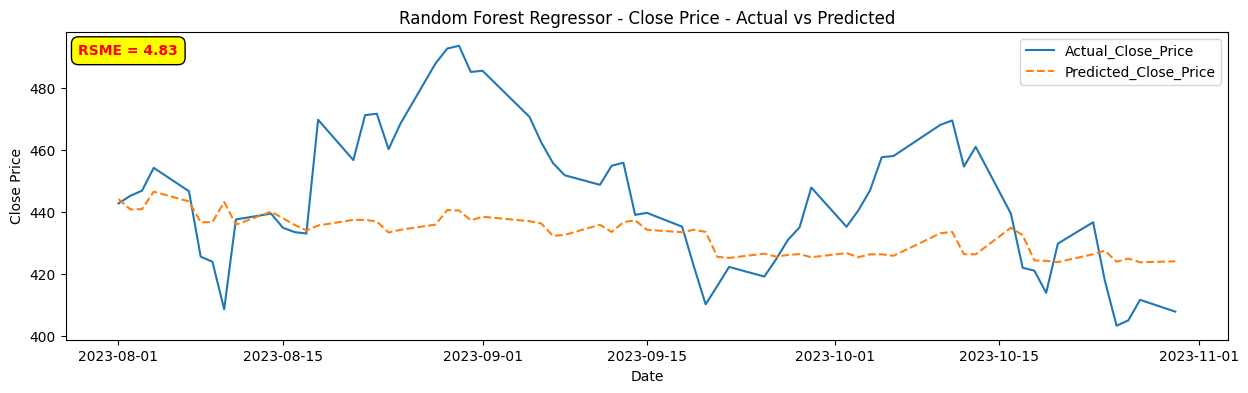

In [30]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Random Forest Regressor - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signals

In [31]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif result_df["Predicted"][i + 1] < result_df["Actual"][i]:
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Price-Prediction-Already-Lower,0.00,0,0,10000.00
1,2023-08-02,445.149994,Price-Prediction-Already-Lower,0.00,0,0,10000.00
2,2023-08-03,446.799988,Price-Prediction-Already-Lower,0.00,0,0,10000.00
3,2023-08-04,454.170013,Price-Prediction-Already-Lower,0.00,0,0,10000.00
4,2023-08-07,446.640015,Price-Prediction-Already-Lower,0.00,0,0,10000.00
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Price-Prediction-Already-Lower,0.00,0,0,11541.50
58,2023-10-24,417.790009,Buy,11280.33,27,261,11541.33
59,2023-10-25,403.260010,Bought-Holding,10888.02,27,261,11149.02
60,2023-10-26,405.000000,Bought-Holding,10935.00,27,261,11196.00


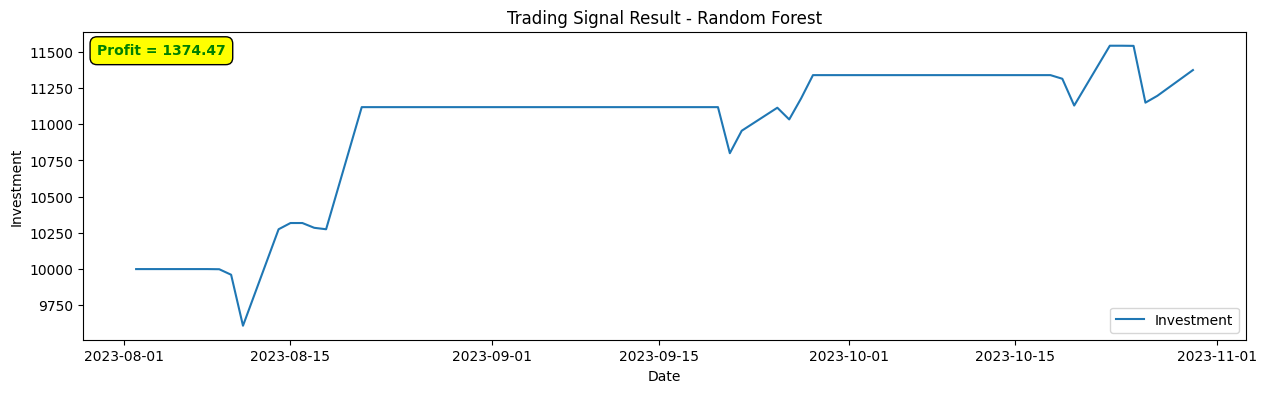

In [32]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result - Random Forest")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Ridge Regression

In [33]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.1, 0.5, 1.0, 1.5,
          2.0, 2.5, 5.0, 7.5, 10.0]

for alpha in alphas:
    with mlflow.start_run():
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)

        y_pred = ridge.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)

        mlflow.set_tag("model", "Ridge")
        mlflow.log_metric("RMSE", RMSE)

        print(f"Ridge - RMSE: {RMSE:.2f}")

Ridge - RMSE: 3.57
Ridge - RMSE: 3.71
Ridge - RMSE: 3.76
Ridge - RMSE: 3.78
Ridge - RMSE: 3.80
Ridge - RMSE: 3.82
Ridge - RMSE: 3.95
Ridge - RMSE: 4.09
Ridge - RMSE: 4.24


### Retrive the best model

In [34]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'Ridge'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Ridge - RMSE: {RMSE}")

Best Run ID: 6dd255bb463144b89fd2aba02c3d5e4b


Ridge - RMSE: 3.5650550859815127


### Plot Actual and Predicted

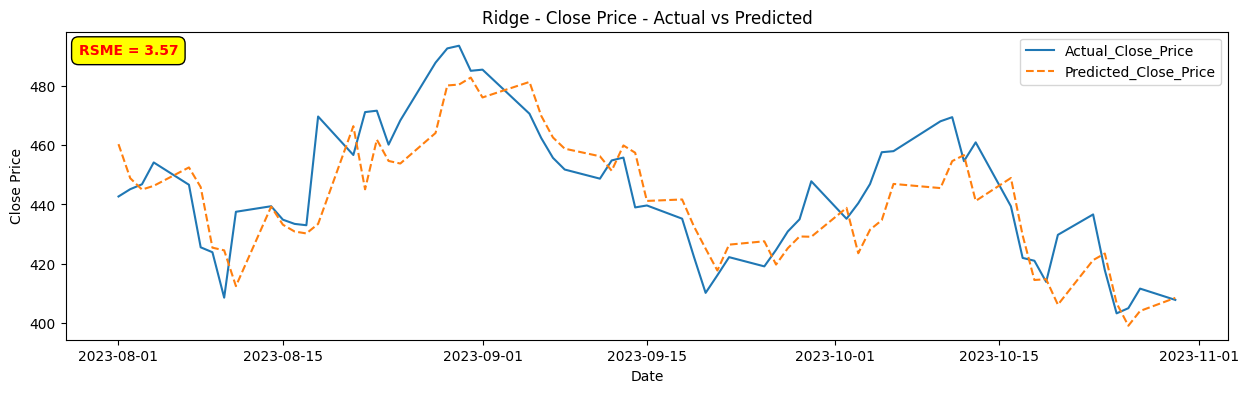

In [35]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Ridge - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signal

In [36]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks = int(amount / result_df["Actual"][i])
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Buy,9739.18,22,260,9999.18
1,2023-08-02,445.149994,Sell,0.00,0,0,10053.30
2,2023-08-03,446.799988,Price-Prediction-Already-Lower,0.00,0,0,10053.30
3,2023-08-04,454.170013,Price-Prediction-Already-Lower,0.00,0,0,10053.30
4,2023-08-07,446.640015,Price-Prediction-Already-Lower,0.00,0,0,10053.30
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Price-Prediction-Already-Lower,0.00,0,0,10849.25
58,2023-10-24,417.790009,Price-Prediction-Already-Lower,0.00,0,0,10849.25
59,2023-10-25,403.260010,Price-Prediction-Already-Lower,0.00,0,0,10849.25
60,2023-10-26,405.000000,Price-Prediction-Already-Lower,0.00,0,0,10849.25


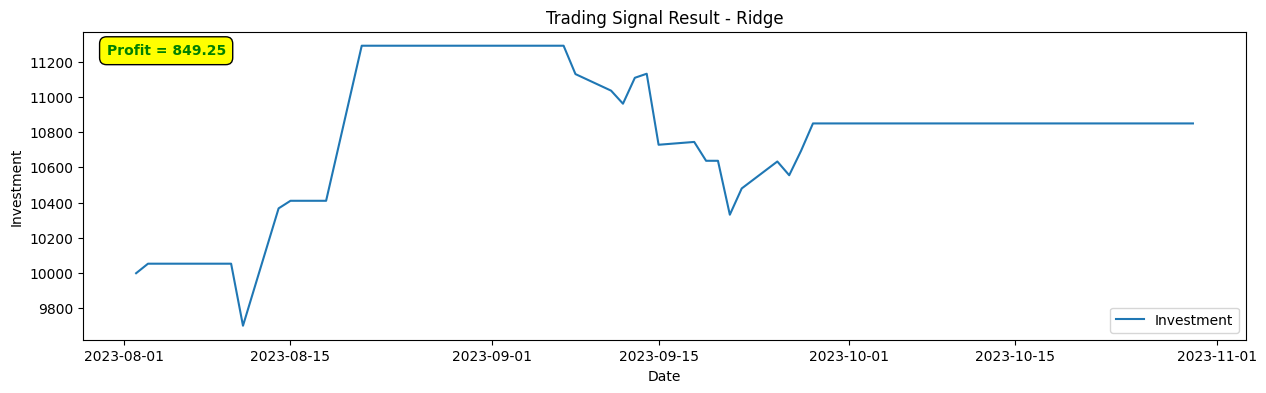

In [37]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result - Ridge")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## LASSO

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up a range of alpha values to test
alphas = [0, 0.0001, 0.0005, 0.001,
          0.005, 0.01, 0.05, 0.1,
          0.5, 1, 2, 2.5, 3,
          3.5, 4, 4.5, 5]

for alpha in alphas:
    with mlflow.start_run():
        lr = Lasso(alpha=alpha, max_iter=10000)
        lr.fit(X_train_scaled, y_train)

        y_pred = lr.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)

        RMSE = math.sqrt(MSE)
        mlflow.set_tag("model", "Lasso")
        mlflow.log_metric("RMSE", RMSE)

        print(f"Lasso - RMSE: {RMSE:.2f}")

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+04, tolerance: 2.941e+02 Linear regression models with null weigh

Lasso - RMSE: 3.47


/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+04, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.47


/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.213e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.47


/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.47
Lasso - RMSE: 3.47
Lasso - RMSE: 3.48
Lasso - RMSE: 3.61
Lasso - RMSE: 3.58
Lasso - RMSE: 3.47
Lasso - RMSE: 3.57
Lasso - RMSE: 3.75
Lasso - RMSE: 3.88
Lasso - RMSE: 3.97
Lasso - RMSE: 4.06
Lasso - RMSE: 4.16
Lasso - RMSE: 4.26
Lasso - RMSE: 4.36


### Retrive the best model


In [39]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'Lasso'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Lasso - RMSE: {RMSE}")

Best Run ID: 469fcbd60c6642d7bccd0a773a2f1a29


Lasso - RMSE: 3.4659415756258483


### Plot Actual and Predicted

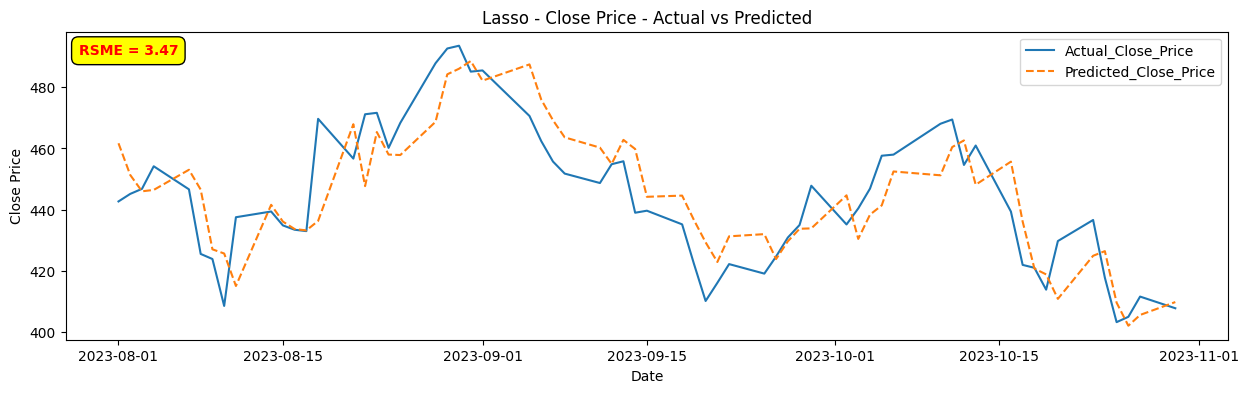

In [40]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Lasso - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signals

In [41]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks = int(amount / result_df["Actual"][i])
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Buy,9739.18,22,260,9999.18
1,2023-08-02,445.149994,Bought-Holding,9793.30,22,260,10053.30
2,2023-08-03,446.799988,Sell,0.00,0,0,10089.60
3,2023-08-04,454.170013,Price-Prediction-Already-Lower,0.00,0,0,10089.60
4,2023-08-07,446.640015,Price-Prediction-Already-Lower,0.00,0,0,10089.60
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Price-Prediction-Already-Lower,0.00,0,0,10542.76
58,2023-10-24,417.790009,Price-Prediction-Already-Lower,0.00,0,0,10542.76
59,2023-10-25,403.260010,Price-Prediction-Already-Lower,0.00,0,0,10542.76
60,2023-10-26,405.000000,Buy,10530.00,26,12,10542.00


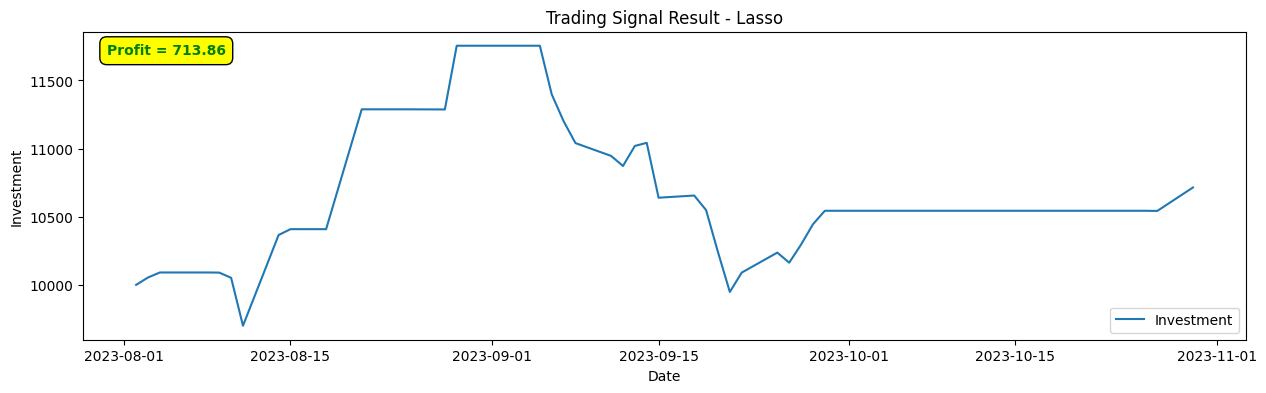

In [42]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result - Lasso")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Extreme Gradient Boosting (XGBoost) Regressors


In [43]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

def objective(params):
    with mlflow.start_run():
        # mlflow.log_params(params) # Check here Anku
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        y_pred = booster.predict(valid)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)
        mlflow.set_tag("model", "XGBoost")
        mlflow.log_metric("RMSE", RMSE)

    return {"loss": RMSE, "status": STATUS_OK}

In [44]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42,
}

best_result = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=Trials()
)

[0]	validation-rmse:189.23848                         
[1]	validation-rmse:164.19503                         
[2]	validation-rmse:144.43401                         
[3]	validation-rmse:125.34939                         
[4]	validation-rmse:110.37876                         
[5]	validation-rmse:97.34299                          
[6]	validation-rmse:86.00244                          
[7]	validation-rmse:76.43962                          
[8]	validation-rmse:67.92941                          
[9]	validation-rmse:60.64218                          
[10]	validation-rmse:54.35302                         
[11]	validation-rmse:48.07382                         
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:43.98183                         
[13]	validation-rmse:39.75328                         
[14]	validation-rmse:36.39231                         
[15]	validation-rmse:34.00490                         
[16]	validation-rmse:31.56986                         
[17]	validation-rmse:30.01617                         
[18]	validation-rmse:28.67775                         
[19]	validation-rmse:27.66356                         
[20]	validation-rmse:26.55930                         
[21]	validation-rmse:25.96888                         
[22]	validation-rmse:25.20294                         
[23]	validation-rmse:24.86059                         
[24]	validation-rmse:24.44650                         
[25]	validation-rmse:24.09090                         
[26]	validation-rmse:23.95929                         
[27]	validation-rmse:23.74960                         
[28]	validation-rmse:23.72023                         
[29]	validation-rmse:23.69719                         
[30]	valid

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:24.26235                                                  
[41]	validation-rmse:24.25697                                                  
[42]	validation-rmse:24.27409                                                  
[43]	validation-rmse:24.26109                                                  
[44]	validation-rmse:24.28220                                                  
[45]	validation-rmse:24.24636                                                  
[46]	validation-rmse:24.25797                                                  
[47]	validation-rmse:24.27539                                                  
[48]	validation-rmse:24.26182                                                  
[49]	validation-rmse:24.27544                                                  
[50]	validation-rmse:24.26782                                                  
[51]	validation-rmse:24.26187                                                  
[52]	validation-rmse:24.26908           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:20.27736                                                  
[36]	validation-rmse:20.27280                                                  
[37]	validation-rmse:20.27260                                                  
[38]	validation-rmse:20.27427                                                  
[39]	validation-rmse:20.27498                                                  
[40]	validation-rmse:20.27794                                                  
[41]	validation-rmse:20.27839                                                  
[42]	validation-rmse:20.27556                                                  
[43]	validation-rmse:20.27527                                                  
[44]	validation-rmse:20.27463                                                  
[45]	validation-rmse:20.27565                                                  
[46]	validation-rmse:20.27371                                                  
[47]	validation-rmse:20.27388           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:21.83212                                                
[20]	validation-rmse:21.15713                                                
[21]	validation-rmse:20.76388                                                
[22]	validation-rmse:20.48735                                                
[23]	validation-rmse:20.26151                                                
[24]	validation-rmse:20.15087                                                
[25]	validation-rmse:20.08678                                                
[26]	validation-rmse:20.04008                                                
[27]	validation-rmse:20.03258                                                
[28]	validation-rmse:19.96506                                                
[29]	validation-rmse:19.86058                                                
[30]	validation-rmse:19.77082                                                
[31]	validation-rmse:19.68436                                   

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:29.69610                                                  
[42]	validation-rmse:29.72132                                                  
[43]	validation-rmse:29.75544                                                  
[44]	validation-rmse:29.72800                                                  
[45]	validation-rmse:29.71235                                                  
[46]	validation-rmse:29.73065                                                  
[47]	validation-rmse:29.70967                                                  
[48]	validation-rmse:29.73963                                                  
[49]	validation-rmse:29.76425                                                  
[50]	validation-rmse:29.72501                                                  
[51]	validation-rmse:29.76735                                                  
[52]	validation-rmse:29.77453                                                  
[53]	validation-rmse:29.76600           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[26]	validation-rmse:72.98541                                                  
[27]	validation-rmse:72.16051                                                  
[28]	validation-rmse:71.40739                                                  
[29]	validation-rmse:70.91120                                                  
[30]	validation-rmse:70.28566                                                  
[31]	validation-rmse:69.73844                                                  
[32]	validation-rmse:69.41715                                                  
[33]	validation-rmse:69.02902                                                  
[34]	validation-rmse:68.59529                                                  
[35]	validation-rmse:68.25432                                                  
[36]	validation-rmse:67.94684                                                  
[37]	validation-rmse:67.67972                                                  
[38]	validation-rmse:67.06248           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:18.97039                                                  
[13]	validation-rmse:18.97039                                                  
[14]	validation-rmse:18.97045                                                  
[15]	validation-rmse:18.97047                                                  
[16]	validation-rmse:18.97053                                                  
[17]	validation-rmse:18.97080                                                  
[18]	validation-rmse:18.97080                                                  
[19]	validation-rmse:18.97085                                                  
[20]	validation-rmse:18.97106                                                  
[21]	validation-rmse:18.97108                                                  
[22]	validation-rmse:18.97103                                                  
[23]	validation-rmse:18.97103                                                  
[24]	validation-rmse:18.97103           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[26]	validation-rmse:58.05700                                                  
[27]	validation-rmse:57.49994                                                  
[28]	validation-rmse:57.02859                                                  
[29]	validation-rmse:56.61018                                                  
[30]	validation-rmse:56.21493                                                  
[31]	validation-rmse:55.85678                                                  
[32]	validation-rmse:55.56622                                                  
[33]	validation-rmse:54.86884                                                  
[34]	validation-rmse:54.36033                                                  
[35]	validation-rmse:54.15445                                                  
[36]	validation-rmse:53.61934                                                  
[37]	validation-rmse:53.16746                                                  
[38]	validation-rmse:53.02986           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:23.98512                                                  
[20]	validation-rmse:23.98176                                                  
[21]	validation-rmse:23.97855                                                  
[22]	validation-rmse:23.97876                                                  
[23]	validation-rmse:23.97771                                                  
[24]	validation-rmse:23.97785                                                  
[25]	validation-rmse:23.97720                                                  
[26]	validation-rmse:23.97683                                                  
[27]	validation-rmse:23.97706                                                  
[28]	validation-rmse:23.97694                                                  
[29]	validation-rmse:23.97703                                                  
[30]	validation-rmse:23.97725                                                  
[31]	validation-rmse:23.97700           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:20.99280                                                  
[41]	validation-rmse:20.99280                                                  
[42]	validation-rmse:20.99280                                                  
[43]	validation-rmse:20.99280                                                  
[44]	validation-rmse:20.99280                                                  
[45]	validation-rmse:20.99280                                                  
[46]	validation-rmse:20.99280                                                  
[47]	validation-rmse:20.99280                                                  
[48]	validation-rmse:20.99280                                                  
[49]	validation-rmse:20.99280                                                  
[50]	validation-rmse:20.99280                                                  
[51]	validation-rmse:20.99280                                                  
[0]	validation-rmse:132.15259           

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[20]	validation-rmse:20.55257                                                   
[21]	validation-rmse:20.55444                                                   
[22]	validation-rmse:20.55477                                                   
[23]	validation-rmse:20.55555                                                   
[24]	validation-rmse:20.55530                                                   
[25]	validation-rmse:20.55329                                                   
[26]	validation-rmse:20.55258                                                   
[27]	validation-rmse:20.55253                                                   
[28]	validation-rmse:20.55253                                                   
[29]	validation-rmse:20.55311                                                   
[30]	validation-rmse:20.55220                                                   
[31]	validation-rmse:20.55163                                                   
[32]	validation-rmse:20.5516

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:41.12608                                                   
[48]	validation-rmse:40.66088                                                   
[49]	validation-rmse:40.20571                                                   
[50]	validation-rmse:39.80026                                                   
[51]	validation-rmse:39.40203                                                   
[52]	validation-rmse:38.97394                                                   
[53]	validation-rmse:38.62383                                                   
[54]	validation-rmse:38.13151                                                   
[55]	validation-rmse:37.86842                                                   
[56]	validation-rmse:37.57957                                                   
[57]	validation-rmse:37.32212                                                   
[58]	validation-rmse:36.95121                                                   
[59]	validation-rmse:36.7217

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:24.21427                                                   
[30]	validation-rmse:24.21881                                                   
[31]	validation-rmse:24.21480                                                   
[32]	validation-rmse:24.22240                                                   
[33]	validation-rmse:24.22405                                                   
[34]	validation-rmse:24.21920                                                   
[35]	validation-rmse:24.21977                                                   
[36]	validation-rmse:24.21959                                                   
[37]	validation-rmse:24.22041                                                   
[38]	validation-rmse:24.21953                                                   
[39]	validation-rmse:24.21856                                                   
[40]	validation-rmse:24.21906                                                   
[41]	validation-rmse:24.2191

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:64.41540                                                   
[26]	validation-rmse:63.29845                                                   
[27]	validation-rmse:62.38038                                                   
[28]	validation-rmse:61.44400                                                   
[29]	validation-rmse:60.58784                                                   
[30]	validation-rmse:59.75135                                                   
[31]	validation-rmse:59.04293                                                   
[32]	validation-rmse:58.36908                                                   
[33]	validation-rmse:57.75110                                                   
[34]	validation-rmse:57.04342                                                   
[35]	validation-rmse:56.38998                                                   
[36]	validation-rmse:55.78649                                                   
[37]	validation-rmse:54.4192

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:26.57061                                                   
[37]	validation-rmse:26.55961                                                   
[38]	validation-rmse:26.55034                                                   
[39]	validation-rmse:26.63680                                                   
[40]	validation-rmse:26.62735                                                   
[41]	validation-rmse:26.63018                                                   
[42]	validation-rmse:26.65085                                                   
[43]	validation-rmse:26.67884                                                   
[44]	validation-rmse:26.70430                                                   
[45]	validation-rmse:26.75026                                                   
[46]	validation-rmse:26.77018                                                   
[47]	validation-rmse:26.74214                                                   
[48]	validation-rmse:26.7343

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:17.52155                                                   
[32]	validation-rmse:17.52112                                                   
[33]	validation-rmse:17.51859                                                   
[34]	validation-rmse:17.51642                                                   
[35]	validation-rmse:17.52790                                                   
[36]	validation-rmse:17.52967                                                   
[37]	validation-rmse:17.52324                                                   
[38]	validation-rmse:17.53578                                                   
[39]	validation-rmse:17.45684                                                   
[40]	validation-rmse:17.44158                                                   
[41]	validation-rmse:17.44327                                                   
[42]	validation-rmse:17.44916                                                   
[43]	validation-rmse:17.4577

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[32]	validation-rmse:39.76152                                                   
[33]	validation-rmse:38.01152                                                   
[34]	validation-rmse:37.41703                                                   
[35]	validation-rmse:36.87027                                                   
[36]	validation-rmse:35.44279                                                   
[37]	validation-rmse:34.27608                                                   
[38]	validation-rmse:33.13194                                                   
[39]	validation-rmse:31.96250                                                   
[40]	validation-rmse:31.02275                                                   
[41]	validation-rmse:30.67975                                                   
[42]	validation-rmse:29.74223                                                   
[43]	validation-rmse:28.93846                                                   
[44]	validation-rmse:28.2243

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[37]	validation-rmse:22.00715                                                   
[38]	validation-rmse:22.00715                                                   
[39]	validation-rmse:22.00715                                                   
[40]	validation-rmse:22.00715                                                   
[41]	validation-rmse:22.00715                                                   
[42]	validation-rmse:22.00715                                                   
[43]	validation-rmse:22.00715                                                   
[44]	validation-rmse:22.00715                                                   
[45]	validation-rmse:22.00715                                                   
[46]	validation-rmse:22.00715                                                   
[47]	validation-rmse:22.00715                                                   
[48]	validation-rmse:22.00715                                                   
[49]	validation-rmse:22.0071

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[17]	validation-rmse:26.59754                                                   
[18]	validation-rmse:25.64491                                                   
[19]	validation-rmse:25.16415                                                   
[20]	validation-rmse:24.68161                                                   
[21]	validation-rmse:24.26096                                                   
[22]	validation-rmse:23.97046                                                   
[23]	validation-rmse:23.68483                                                   
[24]	validation-rmse:23.48805                                                   
[25]	validation-rmse:23.32085                                                   
[26]	validation-rmse:23.19124                                                   
[27]	validation-rmse:23.07668                                                   
[28]	validation-rmse:22.98847                                                   
[29]	validation-rmse:22.9421

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:23.44030                                                   
[44]	validation-rmse:23.38047                                                   
[45]	validation-rmse:23.42079                                                   
[46]	validation-rmse:23.44722                                                   
[47]	validation-rmse:23.43491                                                   
[48]	validation-rmse:23.46938                                                   
[49]	validation-rmse:23.45866                                                   
[50]	validation-rmse:23.48351                                                   
[51]	validation-rmse:23.47662                                                   
[52]	validation-rmse:23.50212                                                   
[53]	validation-rmse:23.47114                                                   
[54]	validation-rmse:23.52162                                                   
[55]	validation-rmse:23.5011

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:49.26905                                                   
[24]	validation-rmse:49.27229                                                   
[25]	validation-rmse:49.27182                                                   
[26]	validation-rmse:49.25481                                                   
[27]	validation-rmse:49.25209                                                   
[28]	validation-rmse:49.23782                                                   
[29]	validation-rmse:49.24430                                                   
[30]	validation-rmse:49.24338                                                   
[31]	validation-rmse:49.24615                                                   
[32]	validation-rmse:49.24685                                                   
[33]	validation-rmse:49.25311                                                   
[34]	validation-rmse:49.25333                                                   
[35]	validation-rmse:49.2530

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[32]	validation-rmse:17.91495                                                   
[33]	validation-rmse:17.89976                                                   
[34]	validation-rmse:17.87884                                                   
[35]	validation-rmse:17.86940                                                   
[36]	validation-rmse:17.89198                                                   
[37]	validation-rmse:17.89829                                                   
[38]	validation-rmse:17.89667                                                   
[39]	validation-rmse:17.91244                                                   
[40]	validation-rmse:17.90639                                                   
[41]	validation-rmse:17.90636                                                   
[42]	validation-rmse:17.90793                                                   
[43]	validation-rmse:17.91190                                                   
[44]	validation-rmse:17.9055

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[26]	validation-rmse:31.60729
[27]	validation-rmse:31.60428                                                   
[28]	validation-rmse:31.60074                                                   
[29]	validation-rmse:31.59294                                                   
[30]	validation-rmse:31.59078                                                   
[31]	validation-rmse:31.59172                                                   
[32]	validation-rmse:31.59216                                                   
[33]	validation-rmse:31.59164                                                   
[34]	validation-rmse:31.58992                                                   
[35]	validation-rmse:31.58528                                                   
[36]	validation-rmse:31.58526                                                   
[37]	validation-rmse:31.58559                                                   
[38]	validation-rmse:31.58670                                                  

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:21.17245                                                   
[34]	validation-rmse:21.16173                                                   
[35]	validation-rmse:21.14844                                                   
[36]	validation-rmse:21.15719                                                   
[37]	validation-rmse:21.14763                                                   
[38]	validation-rmse:21.13796                                                   
[39]	validation-rmse:21.16232                                                   
[40]	validation-rmse:21.17616                                                   
[41]	validation-rmse:21.17670                                                   
[42]	validation-rmse:21.17246                                                   
[43]	validation-rmse:21.20433                                                   
[44]	validation-rmse:21.21040                                                   
[45]	validation-rmse:21.2233

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:21.08474                                                   
[28]	validation-rmse:21.09452                                                   
[29]	validation-rmse:21.12307                                                   
[30]	validation-rmse:21.12732                                                   
[31]	validation-rmse:21.13643                                                   
[32]	validation-rmse:21.13472                                                   
[33]	validation-rmse:21.13173                                                   
[34]	validation-rmse:21.13403                                                   
[35]	validation-rmse:21.04154                                                   
[36]	validation-rmse:21.03779                                                   
[37]	validation-rmse:21.03825                                                   
[38]	validation-rmse:21.04087                                                   
[39]	validation-rmse:21.0405

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:22.65221                                                   
[28]	validation-rmse:22.61256                                                   
[29]	validation-rmse:22.62295                                                   
[30]	validation-rmse:22.64812                                                   
[31]	validation-rmse:22.64024                                                   
[32]	validation-rmse:22.64960                                                   
[33]	validation-rmse:22.65915                                                   
[34]	validation-rmse:22.65216                                                   
[35]	validation-rmse:22.64399                                                   
[36]	validation-rmse:22.67292                                                   
[37]	validation-rmse:22.62250                                                   
[38]	validation-rmse:22.65099                                                   
[39]	validation-rmse:22.6541

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:35.22299
[35]	validation-rmse:35.18274                                                   
[36]	validation-rmse:35.18434                                                   
[37]	validation-rmse:35.15220                                                   
[38]	validation-rmse:35.14260                                                   
[39]	validation-rmse:35.13833                                                   
[40]	validation-rmse:35.12351                                                   
[41]	validation-rmse:35.10580                                                   
[42]	validation-rmse:35.10552                                                   
[43]	validation-rmse:35.09890                                                   
[44]	validation-rmse:35.09871                                                   
[45]	validation-rmse:35.09935                                                   
[46]	validation-rmse:35.08238                                                  

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:09] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:19.73290                                                   
[31]	validation-rmse:19.72649                                                   
[32]	validation-rmse:19.71011                                                   
[33]	validation-rmse:19.70971                                                   
[34]	validation-rmse:19.71886                                                   
[35]	validation-rmse:19.71635                                                   
[36]	validation-rmse:19.71092                                                   
[37]	validation-rmse:19.71347                                                   
[38]	validation-rmse:19.71485                                                   
[39]	validation-rmse:19.71864                                                   
[40]	validation-rmse:19.71870                                                   
[41]	validation-rmse:19.72144                                                   
[42]	validation-rmse:19.7214

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:42.54354                                                   
[24]	validation-rmse:42.02254                                                   
[25]	validation-rmse:41.52508                                                   
[26]	validation-rmse:41.12154                                                   
[27]	validation-rmse:40.75092                                                   
[28]	validation-rmse:40.45983                                                   
[29]	validation-rmse:40.16948                                                   
[30]	validation-rmse:39.94308                                                   
[31]	validation-rmse:39.66738                                                   
[32]	validation-rmse:39.42839                                                   
[33]	validation-rmse:39.20563                                                   
[34]	validation-rmse:39.02573                                                   
[35]	validation-rmse:38.8434

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:24.00038                                                   
[46]	validation-rmse:23.98832                                                   
[47]	validation-rmse:23.96808                                                   
[48]	validation-rmse:23.92337                                                   
[49]	validation-rmse:23.93295                                                   
[50]	validation-rmse:23.89064                                                   
[51]	validation-rmse:23.87406                                                   
[52]	validation-rmse:23.87086                                                   
[53]	validation-rmse:23.88448                                                   
[54]	validation-rmse:23.94130                                                   
[55]	validation-rmse:23.89594                                                   
[56]	validation-rmse:23.92872                                                   
[57]	validation-rmse:23.8827

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:18.68812
[30]	validation-rmse:18.69114                                                   
[31]	validation-rmse:18.69329                                                   
[32]	validation-rmse:18.68736                                                   
[33]	validation-rmse:18.68125                                                   
[34]	validation-rmse:18.67993                                                   
[35]	validation-rmse:18.67864                                                   
[36]	validation-rmse:18.68117                                                   
[37]	validation-rmse:18.67761                                                   
[38]	validation-rmse:18.68296                                                   
[39]	validation-rmse:18.68542                                                   
[40]	validation-rmse:18.66913                                                   
[41]	validation-rmse:18.67354                                                  

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:21.51258                                                   
[31]	validation-rmse:21.49586                                                   
[32]	validation-rmse:21.53251                                                   
[33]	validation-rmse:21.52898                                                   
[34]	validation-rmse:21.49907                                                   
[35]	validation-rmse:21.50928                                                   
[36]	validation-rmse:21.51178                                                   
[37]	validation-rmse:21.47338                                                   
[38]	validation-rmse:21.48084                                                   
[39]	validation-rmse:21.47278                                                   
[40]	validation-rmse:21.47008                                                   
[41]	validation-rmse:21.47372                                                   
[42]	validation-rmse:21.4637

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:41.83140                                                   
[19]	validation-rmse:41.60465                                                   
[20]	validation-rmse:41.42670                                                   
[21]	validation-rmse:41.25770                                                   
[22]	validation-rmse:41.12616                                                   
[23]	validation-rmse:41.02031                                                   
[24]	validation-rmse:40.92039                                                   
[25]	validation-rmse:40.85710                                                   
[26]	validation-rmse:40.80962                                                   
[27]	validation-rmse:40.78043                                                   
[28]	validation-rmse:40.74780                                                   
[29]	validation-rmse:40.70315                                                   
[30]	validation-rmse:40.6645

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:36.11492                                                   
[47]	validation-rmse:35.92796                                                   
[48]	validation-rmse:35.66418                                                   
[49]	validation-rmse:35.35429                                                   
[50]	validation-rmse:35.07545                                                   
[51]	validation-rmse:34.86328                                                   
[52]	validation-rmse:34.78492                                                   
[53]	validation-rmse:34.58545                                                   
[54]	validation-rmse:34.45830                                                   
[55]	validation-rmse:34.28118                                                   
[56]	validation-rmse:34.15525                                                   
[57]	validation-rmse:34.09213                                                   
[58]	validation-rmse:33.9814

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[26]	validation-rmse:31.11527
[27]	validation-rmse:31.11528                                                   
[28]	validation-rmse:31.11429                                                   
[29]	validation-rmse:31.11185                                                   
[30]	validation-rmse:31.11196                                                   
[31]	validation-rmse:31.11336                                                   
[32]	validation-rmse:31.10435                                                   
[33]	validation-rmse:31.09955                                                   
[34]	validation-rmse:31.09960                                                   
[35]	validation-rmse:31.09912                                                   
[36]	validation-rmse:31.09893                                                   
[37]	validation-rmse:31.09852                                                   
[38]	validation-rmse:31.09881                                                  

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:20.87546                                                   
[35]	validation-rmse:20.87346                                                   
[36]	validation-rmse:20.85931                                                   
[37]	validation-rmse:20.86538                                                   
[38]	validation-rmse:20.86802                                                   
[39]	validation-rmse:20.86751                                                   
[40]	validation-rmse:20.84950                                                   
[41]	validation-rmse:20.86436                                                   
[42]	validation-rmse:20.86004                                                   
[43]	validation-rmse:20.86101                                                   
[44]	validation-rmse:20.86018                                                   
[45]	validation-rmse:20.85647                                                   
[46]	validation-rmse:20.8642

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[15]	validation-rmse:37.66440                                                   
[16]	validation-rmse:34.17288                                                   
[17]	validation-rmse:31.56175                                                   
[18]	validation-rmse:29.29013                                                   
[19]	validation-rmse:27.53053                                                   
[20]	validation-rmse:25.72791                                                   
[21]	validation-rmse:24.50854                                                   
[22]	validation-rmse:23.45950                                                   
[23]	validation-rmse:22.57821                                                   
[24]	validation-rmse:21.80525                                                   
[25]	validation-rmse:21.21290                                                   
[26]	validation-rmse:20.83292                                                   
[27]	validation-rmse:20.4874

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[66]	validation-rmse:21.70793                                                   
[67]	validation-rmse:21.70365                                                   
[68]	validation-rmse:21.67435                                                   
[69]	validation-rmse:21.66816                                                   
[70]	validation-rmse:21.67290                                                   
[71]	validation-rmse:21.63206                                                   
[72]	validation-rmse:21.61507                                                   
[73]	validation-rmse:21.60514                                                   
[74]	validation-rmse:21.62119                                                   
[75]	validation-rmse:21.63476                                                   
[76]	validation-rmse:21.52005                                                   
[77]	validation-rmse:21.51870                                                   
[78]	validation-rmse:21.4227

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[24]	validation-rmse:55.35391                                                   
[25]	validation-rmse:54.43400                                                   
[26]	validation-rmse:54.14452                                                   
[27]	validation-rmse:53.59481                                                   
[28]	validation-rmse:53.36614                                                   
[29]	validation-rmse:52.92519                                                   
[30]	validation-rmse:52.77343                                                   
[31]	validation-rmse:52.45668                                                   
[32]	validation-rmse:52.21448                                                   
[33]	validation-rmse:51.97282                                                   
[34]	validation-rmse:51.90944                                                   
[35]	validation-rmse:51.69981                                                   
[36]	validation-rmse:51.5249

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:37] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[32]	validation-rmse:19.74701                                                   
[33]	validation-rmse:19.74345                                                   
[34]	validation-rmse:19.74560                                                   
[35]	validation-rmse:19.75386                                                   
[36]	validation-rmse:19.75016                                                   
[37]	validation-rmse:19.74744                                                   
[38]	validation-rmse:19.74486                                                   
[39]	validation-rmse:19.74430                                                   
[40]	validation-rmse:19.74977                                                   
[41]	validation-rmse:19.75016                                                   
[42]	validation-rmse:19.75318                                                   
[43]	validation-rmse:19.75318                                                   
[44]	validation-rmse:19.7538

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[55]	validation-rmse:27.36630                                                   
[56]	validation-rmse:27.15770                                                   
[57]	validation-rmse:27.05257                                                   
[58]	validation-rmse:26.92336                                                   
[59]	validation-rmse:26.74813                                                   
[60]	validation-rmse:26.75986                                                   
[61]	validation-rmse:26.66139                                                   
[62]	validation-rmse:26.52111                                                   
[63]	validation-rmse:26.55193                                                   
[64]	validation-rmse:26.50509                                                   
[65]	validation-rmse:26.57213                                                   
[66]	validation-rmse:26.71323                                                   
[67]	validation-rmse:26.8219

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:38.18742                                                   
[29]	validation-rmse:38.18782                                                   
[30]	validation-rmse:38.18800                                                   
[31]	validation-rmse:38.18800                                                   
[32]	validation-rmse:38.18781                                                   
[33]	validation-rmse:38.18857                                                   
[34]	validation-rmse:38.19011                                                   
[35]	validation-rmse:38.19046                                                   
[36]	validation-rmse:38.19121                                                   
[37]	validation-rmse:38.19100                                                   
[38]	validation-rmse:38.19104                                                   
[39]	validation-rmse:38.19104                                                   
[40]	validation-rmse:38.1908

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:33.63731                                                   
[23]	validation-rmse:33.50381                                                   
[24]	validation-rmse:33.35440                                                   
[25]	validation-rmse:33.24156                                                   
[26]	validation-rmse:33.14141                                                   
[27]	validation-rmse:33.07173                                                   
[28]	validation-rmse:33.01517                                                   
[29]	validation-rmse:32.97152                                                   
[30]	validation-rmse:32.90573                                                   
[31]	validation-rmse:32.84607                                                   
[32]	validation-rmse:32.76822                                                   
[33]	validation-rmse:32.71246                                                   
[34]	validation-rmse:32.6804

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[39]	validation-rmse:33.60824                                                   
[40]	validation-rmse:33.61689                                                   
[41]	validation-rmse:33.60101                                                   
[42]	validation-rmse:33.59216                                                   
[43]	validation-rmse:33.59733                                                   
[44]	validation-rmse:33.62005                                                   
[45]	validation-rmse:33.63028                                                   
[46]	validation-rmse:33.63703                                                   
[47]	validation-rmse:33.63881                                                   
[48]	validation-rmse:33.63155                                                   
[49]	validation-rmse:33.64126                                                   
[50]	validation-rmse:33.65434                                                   
[51]	validation-rmse:33.6609

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:19.65593                                                   
[35]	validation-rmse:19.63064                                                   
[36]	validation-rmse:19.61670                                                   
[37]	validation-rmse:19.62427                                                   
[38]	validation-rmse:19.61748                                                   
[39]	validation-rmse:19.61291                                                   
[40]	validation-rmse:19.62367                                                   
[41]	validation-rmse:19.61973                                                   
[42]	validation-rmse:19.62532                                                   
[43]	validation-rmse:19.63218                                                   
[44]	validation-rmse:19.62119                                                   
[45]	validation-rmse:19.62750                                                   
[46]	validation-rmse:19.6312

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[24]	validation-rmse:26.53700
[25]	validation-rmse:26.53700                                                   
[26]	validation-rmse:26.53700                                                   
[27]	validation-rmse:26.53700                                                   
[28]	validation-rmse:26.53700                                                   
[29]	validation-rmse:26.53700                                                   
[30]	validation-rmse:26.53700                                                   
[31]	validation-rmse:26.53700                                                   
[32]	validation-rmse:26.53700                                                   
[33]	validation-rmse:26.53700                                                   
[34]	validation-rmse:26.53700                                                   
[35]	validation-rmse:26.53700                                                   
[36]	validation-rmse:26.53700                                                  

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:45.95674                                                   
[22]	validation-rmse:45.34053                                                   
[23]	validation-rmse:44.53915                                                   
[24]	validation-rmse:43.61676                                                   
[25]	validation-rmse:43.29352                                                   
[26]	validation-rmse:42.59428                                                   
[27]	validation-rmse:42.33340                                                   
[28]	validation-rmse:41.80052                                                   
[29]	validation-rmse:41.34083                                                   
[30]	validation-rmse:40.93605                                                   
[31]	validation-rmse:40.59350                                                   
[32]	validation-rmse:40.36177                                                   
[33]	validation-rmse:40.0838

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:19.37921                                                   
[35]	validation-rmse:19.20107                                                   
[36]	validation-rmse:19.02107                                                   
[37]	validation-rmse:18.79047                                                   
[38]	validation-rmse:18.69327                                                   
[39]	validation-rmse:18.49809                                                   
[40]	validation-rmse:18.42692                                                   
[41]	validation-rmse:18.35523                                                   
[42]	validation-rmse:18.29457                                                   
[43]	validation-rmse:18.19983                                                   
[44]	validation-rmse:18.18537                                                   
[45]	validation-rmse:18.09056                                                   
[46]	validation-rmse:18.0815

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:41.64193                                                   
[48]	validation-rmse:41.64193                                                   
[49]	validation-rmse:41.64193                                                   
[50]	validation-rmse:41.64193                                                   
[51]	validation-rmse:41.64193                                                   
[52]	validation-rmse:41.64193                                                   
[53]	validation-rmse:41.64193                                                   
[54]	validation-rmse:41.64193                                                   
[55]	validation-rmse:41.64193                                                   
[56]	validation-rmse:41.64193                                                   
[57]	validation-rmse:41.64193                                                   
[58]	validation-rmse:41.64193                                                   
[59]	validation-rmse:41.6419

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:64.36321                                                   
[31]	validation-rmse:63.60680                                                   
[32]	validation-rmse:62.75265                                                   
[33]	validation-rmse:61.90176                                                   
[34]	validation-rmse:61.22322                                                   
[35]	validation-rmse:60.76844                                                   
[36]	validation-rmse:60.22093                                                   
[37]	validation-rmse:59.49415                                                   
[38]	validation-rmse:58.94478                                                   
[39]	validation-rmse:58.61144                                                   
[40]	validation-rmse:58.19697                                                   
[41]	validation-rmse:57.72899                                                   
[42]	validation-rmse:57.6228

### Retrive the best model


In [45]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'XGBoost'",
)[0].info.run_id

print(f"Best Run ID: {best_run_id}")
loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"XGBoost - RMSE: {RMSE}")

Best Run ID: e064a6d559604d6a94b3885328d18fc9


XGBoost - RMSE: 4.178424279191564



/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:28:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


### Plot Actual and Predicted

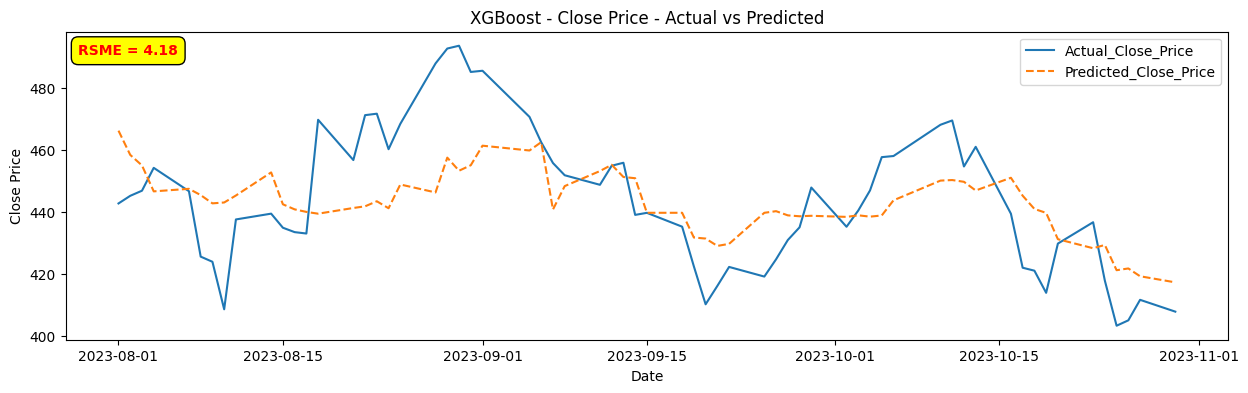

In [46]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("XGBoost - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signal

In [47]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks = int(amount / result_df["Actual"][i])
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_54873/921435226.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Buy,9739.18,22,260,9999.18
1,2023-08-02,445.149994,Bought-Holding,9793.30,22,260,10053.30
2,2023-08-03,446.799988,Sell,0.00,0,0,10089.60
3,2023-08-04,454.170013,Price-Prediction-Already-Lower,0.00,0,0,10089.60
4,2023-08-07,446.640015,Price-Prediction-Already-Lower,0.00,0,0,10089.60
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Price-Prediction-Already-Lower,0.00,0,0,11617.25
58,2023-10-24,417.790009,Buy,11280.33,27,336,11616.33
59,2023-10-25,403.260010,Bought-Holding,10888.02,27,336,11224.02
60,2023-10-26,405.000000,Bought-Holding,10935.00,27,336,11271.00


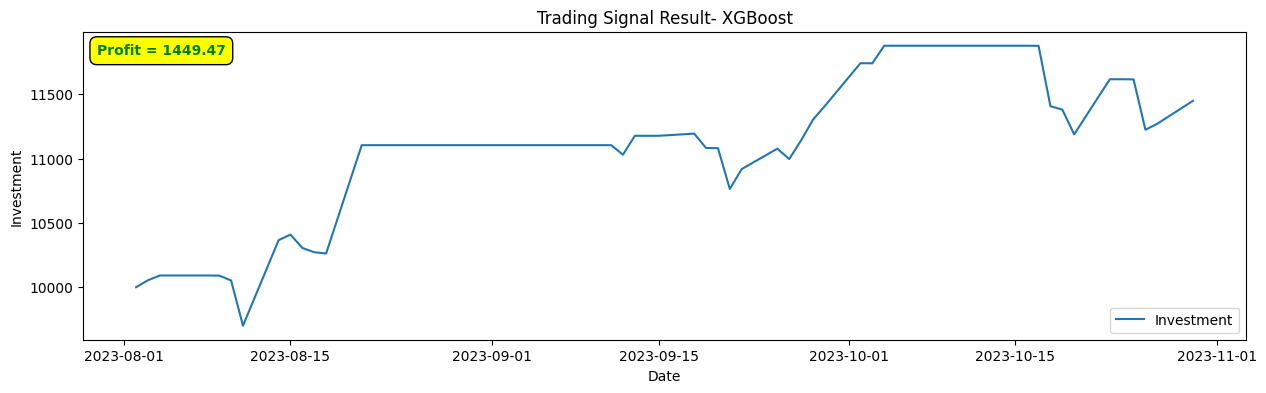

In [48]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result- XGBoost")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()